# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. 

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.


# Summary of Findings

### Introduction
This dataset contains the power outages in the US from 2000 to 2016. It includes regional climate information, outage events information (start, end, duration, restoration, etc.), electricty consumption, economic characteristics, and land-use characteristics.

The question we are going to answer is what are the characteristics of major power outages with higher severity? By investigating some charactersistics in the dataset, we can find correlations between power outage and the other characteristics in the dataset.

### Cleaning and EDA
Upon exploring the dataset, we found that there were unnecessary rows in the beginning of the dataset. We removed those rows. We also removed the "Varibles" column and the "Units" row. We converted the variables to the right data type. 

We selected the outage duration to be 2 days to classify the power outage to be a major one. We also considerd the number of customers affected to be greater than 67,000 and the demand loss to be greater than 125MW, to consider the power outage to be a severe one. 

We conducted univariate analysis on the outage duration since it pertains to our question. We conducted bivariate analysis between the cause category column vs customers affected/demand loss. 

To better visualize the data, we used folium to map out the information of major and severe power outage for each state in the US. We could observe that the coastal states experienced more power outages than the inland states. 

### Assessment of Missingness
Before conducting any analyses, we thought that the customers affected column was going to be dependent on the cause category since there could be a category like severe weather were the number of customers affected could not be reported correctly because there could be a lot of missing/lost people.

But after conducting the Kolmogorov–Smirnov test, we noticed the p value to be extremely low ( << 5%). Hence we could conclude that the missingness in the customers affected column was not dependent on the cause category column. 

Demand loss is MAR dependent on cause category.
Customers affected was MAR dependent on Anomaly level. 

### Hypothesis Test
Null hypothesis: The states that are next to water suffered the same outage duration as those that are inland

Alternative hypothesis: The states that are coastline have suffered longer major outages than those that are inland

Test statistics: Kolmogorov–Smirnov test

Significance level: 5%

We reject the null hypothesis which means that the states along the coastline experienced longer power outages than the inland states. 

# Code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Below packages are for plotting US map
import folium
from folium.plugins import StripePattern
import geopandas as gpd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# Introduction




###  **Cleaning and EDA**

In [ ]:
# The given excel file has its first 3 rows to be notes. We cut it out then use the first row of the truncated 
# dataframe to be convert them to be columns' names
org_outage = pd.read_excel('outage.xlsx')
df = org_outage.iloc[4:,:].copy().reset_index(drop=True)
mod_outage = df.copy()
mod_outage.columns = df.iloc[0]
# This is for dropping the variables column that only have 1 cell to be units that represent the units of
# each column
mod_outage = mod_outage.drop(mod_outage.index[0])
# this units dictionary is for convenience to use the right unit from each colum
units_dict = mod_outage.iloc[:1,:].T.to_dict()[1]
outage = mod_outage.iloc[1:,1:].reset_index(drop=True)
outage

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,20:00:00,severe weather,NaN,NaN,3060,NaN,70000,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736,276286,10673,2595696,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,18:39:00,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860,284978,9898,2640737,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,22:00:00,severe weather,heavy wind,NaN,3000,NaN,70000,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.0977,34.501,37.366,2300291,276463,10150,2586905,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,2012-06-20 00:00:00,23:00:00,severe weather,thunderstorm,NaN,2550,NaN,68200,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.9941,33.5433,34.4393,2317336,278466,11010,2606813,88.8954,10.6822,0.422355,51598,48156,1.07148,0.6,5364,277627,1.93209,2.2,5380443,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,2015-07-19 00:00:00,07:00:00,severe weather,NaN,NaN,1740,250,250000,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9826,36.2059,29.7795,2374674,289044,9812,2673531,88.8216,10.8113,0.367005,54431,49844,1.09203,1.7,4873,292023,1.6687,2.2,5489594,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,1530,2011,12,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06 00:00:00,08:00:00,2011-12-06 00:00:00,20:00:00,public appeal,NaN,NaN,720,155,34500,8.41,7.8,6.2,7.56,488853,438133,386693,1313678,37.2125,33.3516,29.4359,330738,60017,3639,394394,83.8598,15.2175,0.922681,57012,47586,1.19808,9.8,934,39067,2.39076,0.5,685326,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177
1530,1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,NaN,NaN,NaN,fuel supply emergency,Coal,NaN,NaN,1650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309997,53709,2331,366037,84.6901,14.6731,0.636821,42913,48909,0.877405,3.5,1019,27868,3.65652,0.7,649422,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177
1531,1532,2009,8,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29 00:00:00,22:54:00,2009-08-29 00:00:00,23:53:00,islanding,NaN,NaN,59,84,NaN,9.25,7.47,5.53,7.67,337874,370771,215406,924051,36.5644,40.1245,23.3111,367206,65971,3052,436229,84.1773,15.123

In [ ]:
# merge outage.start, outage restoration date & time 
outage = outage.assign(
    **{'OUTAGE.START' : (outage['OUTAGE.START.DATE'].apply(pd.Timestamp) + 
outage['OUTAGE.START.TIME'].astype(str).apply(pd.to_timedelta))
      , 'OUTAGE.RESTORATION' : (outage['OUTAGE.RESTORATION.DATE'].apply(pd.Timestamp) + \
outage['OUTAGE.RESTORATION.TIME'].astype(str).apply(pd.to_timedelta))}
).drop(columns=['OUTAGE.START.DATE','OUTAGE.START.TIME','OUTAGE.RESTORATION.DATE','OUTAGE.RESTORATION.TIME'])

# Convert to the right type
float_col = ['ANOMALY.LEVEL','OUTAGE.DURATION',
'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE',
       'IND.PRICE', 'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES',
       'TOTAL.SALES', 'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN',
       'RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 
       'PC.REALGSP.USA', 'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP',
       'TOTAL.REALGSP', 'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 
       'POPPCT_URBAN', 'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC',
       'POPDEN_RURAL', 'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND',
       'PCT_WATER_TOT', 'PCT_WATER_INLAND']
int_lst = ['RES.CUSTOMERS', 'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS']
outage[float_col] =outage[float_col].astype(float)
outage[int_lst] =outage[int_lst].astype(int)

# We then sort by year 
sort_year = outage.sort_values(['YEAR','MONTH','U.S._STATE']).reset_index(drop=True)
sort_year[['CAUSE.CATEGORY.DETAIL','HURRICANE.NAMES']].apply(pd.Series.value_counts).sort_values('CAUSE.CATEGORY.DETAIL')
sort_year

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,811,2000,1,South Carolina,SC,SERC,Southeast,-1.6,cold,severe weather,winter storm,NaN,7440.0,450.0,133000.0,7.38,6.37,3.64,5.60,2400821.0,1350477.0,2759297.0,6586660.0,36.449748,20.503214,41.892203,1764298,274003,5077,2059496,85.666493,13.304372,0.246517,36388.0,44745.0,0.813231,1.1,5210.0,146434.0,3.557917,1.7,4024223.0,66.33,10.55,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923,2000-01-23 08:00:00,2000-01-28 12:00:00
1,813,2000,1,South Carolina,SC,SERC,Southeast,-1.6,cold,severe weather,winter storm,NaN,6600.0,300.0,81000.0,7.38,6.37,3.64,5.60,2400821.0,1350477.0,2759297.0,6586660.0,36.449748,20.503214,41.892203,1764298,274003,5077,2059496,85.666493,13.304372,0.246517,36388.0,44745.0,0.813231,1.1,5210.0,146434.0,3.557917,1.7,4024223.0,66.33,10.55,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923,2000-01-29 22:00:00,2000-02-03 12:00:00
2,1464,2000,3,Maine,ME,NPCC,Northeast,-1.1,cold,intentional attack,vandalism,NaN,NaN,NaN,NaN,12.92,9.86,7.07,9.97,281853.0,292566.0,269741.0,864735.0,32.594147,33.833024,31.193487,650326,102433,1966,770617,84.390300,13.292336,0.255120,36202.0,44745.0,0.809074,3.1,1095.0,46233.0,2.368438,0.3,1277072.0,38.66,12.45,1428.0,1360.0,26.7,1.17,0.39,87.176371,12.823629,6.540418,2000-03-14 21:06:00,NaT
3,1360,2000,3,New Mexico,NM,WECC,Southwest,-1.1,cold,system operability disruption,transmission interruption,NaN,0.0,1040.0,500000.0,8.31,7.03,4.13,6.35,369300.0,495042.0,452568.0,1437691.0,25.687022,34.433129,31.478809,728046,113364,1493,853771,85.274154,13.278034,0.174871,37950.0,44745.0,0.848139,1.3,1583.0,69116.0,2.290352,0.5,1821204.0,77.43,23.68,1928.5,1446.2,3.9,0.68,0.28,99.759849,0.240151,0.240151,2000-03-18 19:08:00,2000-03-18 19:08:00
4,236,2000,3,Texas,TX,TRE,South,-1.1,cold,system operability disruption,transmission interruption,NaN,70.0,400.0,100000.0,7.43,6.80,4.01,5.91,6507440.0,5925328.0,8359654.0,21870637.0,29.754232,27.092617,38.223185,8023266,1093414,61280,9299829,86.273264,11.757356,0.658937,45102.0,44745.0,1.007979,1.7,30908.0,944631.0,3.271965,10.3,20944499.0,84.70,9.35,2435.3,1539.9,15.2,3.35,0.58,97.258336,2.742036,2.090873,2000-03-18 16:00:00,2000-03-18 17:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,606,2016,7,Pennsylvania,PA,RFC,Northeast,-0.3,normal,system operability disruption,voltage reduction,NaN,278.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5335555,696080,23372,6055013,88.117978,11.495929,0.385994,50978.0,50660.0,1.006277,4.2,10659.0,651857.0,1.635175,4.1,12787085.0,78.66,7.98,2123.4,1528.6,67.7,10.52,1.48,97.153342,2.848830,1.222478,2016-07-23 15:15:00,2016-07-23 19:53:00
1530,37,2016,7,Tennessee,TN,SERC,Central,-0.3,normal,system operability disruption,public appeal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2812287,480032,1193,3293512,85.388698,14.575080,0.036223,43720.0,50660.0,0.863008,3.0,1813.0,290712.0,0.623641,0.5,6649404.0,66.39,12.02,1450.3,1076.2,55.6,7.05,1.72,97.843109,2.156891,2.156891,2016-07-13 15:00:00,NaT
1531,172,2016,7,Texas,TX,TRE,South,-0.3,normal,severe weather,NaN,NaN,1455.0,NaN,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105

**Conducting univariate analysis to determine which outages are major** 

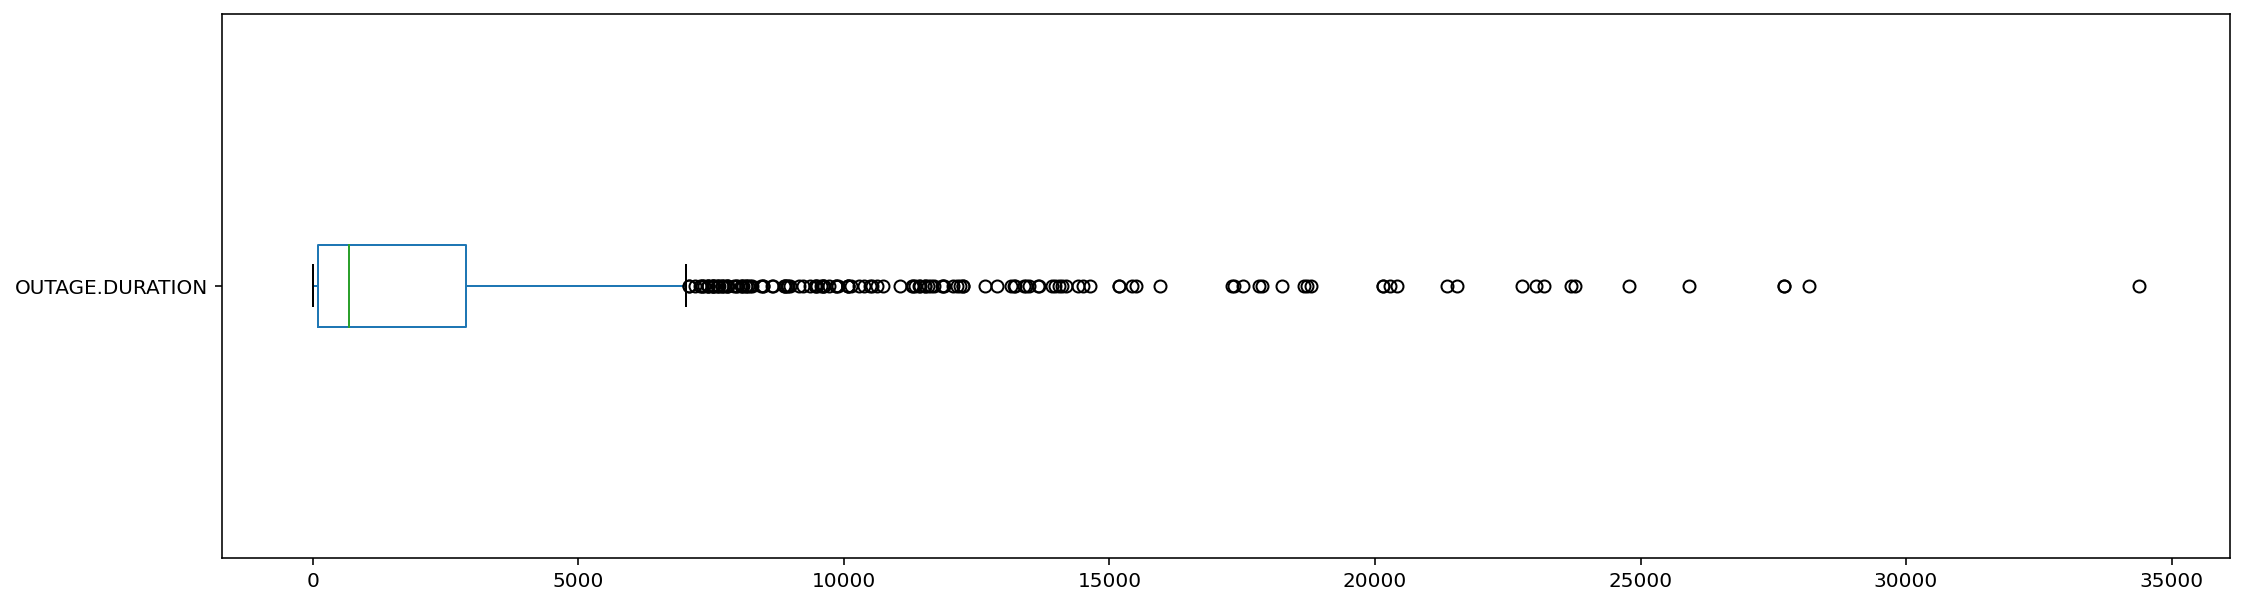

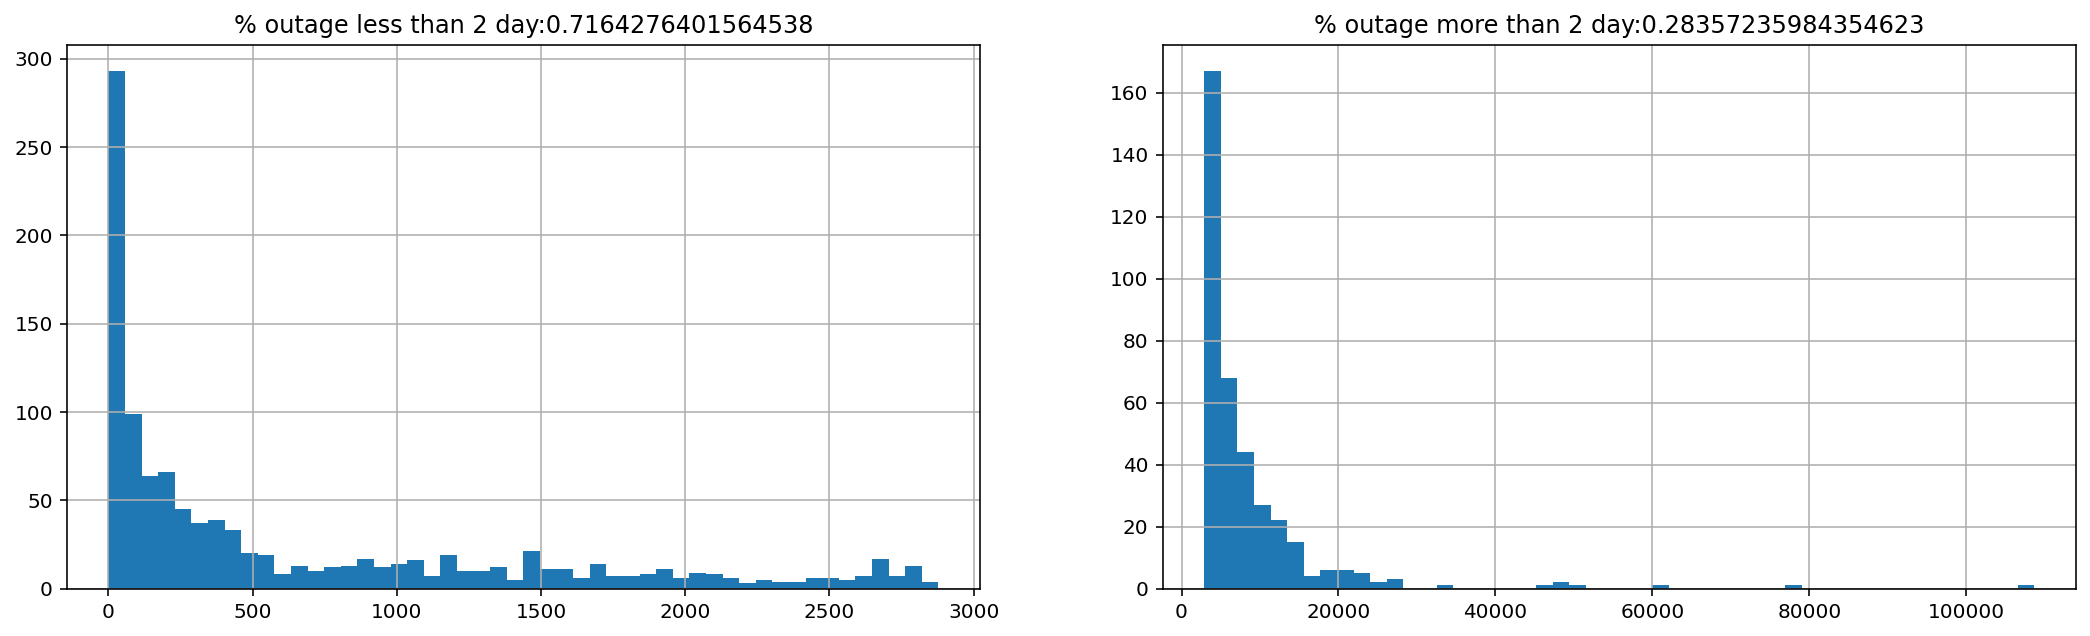

In [ ]:
# univariate analysis to determine which outages are major
figure, axis = plt.subplots(figsize=(18, 5))
box = sort_year[sort_year['OUTAGE.DURATION']<40000]['OUTAGE.DURATION'].plot.box(vert=False)
plt.show()

# Get the outage duration then calculate the upper quartile 
data = sort_year.copy()['OUTAGE.DURATION'].dropna()
outage_dur_upper_quartile = np.percentile(data, 75)

# Set the duration to be 2 days
duration = outage_dur_upper_quartile
trunc_per_cent = (sort_year['OUTAGE.DURATION']<duration).mean()

figure, axis = plt.subplots(1, 2, figsize=(18,5))
sort_year[sort_year['OUTAGE.DURATION']<duration]['OUTAGE.DURATION'].hist(ax = axis[0],bins=50)
sort_year[sort_year['OUTAGE.DURATION']>=duration]['OUTAGE.DURATION'].hist(ax = axis[1],bins=50)
axis[0].set_title(f'% outage less than 2 day:{trunc_per_cent}')
axis[1].set_title(f'% outage more than 2 day:{1-trunc_per_cent}')
plt.show()

The question that we are tackling prompts us to classify a major and a severe outage. After conducting univariate analysis for the "OUTAGE.DURATION" column, we observe that that the number of outages which last for more than 2 days is around 28.35%. From the box and whisker plot, we can observe that the upper quartile is 2 days (2880 minutes). Also, from intuition we can say that any outage which lasts more than 2 days (2880 minutes) should be considered as a major outage. Henceforth in our analysis, we will consider only the outages that last more than 2880 minutes.

In [ ]:
major_outage = outage[outage['OUTAGE.DURATION'] > outage_dur_upper_quartile]
major_outage

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,NaN,3060.0,NaN,70000.0,11.60,9.18,6.81,9.28,2332915.0,2114774.0,2113291.0,6562520.0,35.549073,32.225029,32.202431,2308736,276286,10673,2595696,88.944776,10.644005,0.411181,51268.0,47586.0,1.077376,1.6,4802.0,274182.0,1.751391,2.2,5348119.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
2,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,NaN,3000.0,NaN,70000.0,10.87,8.19,6.07,8.15,1467293.0,1801683.0,1951295.0,5222116.0,28.097672,34.501015,37.365983,2300291,276463,10150,2586905,88.920583,10.687018,0.392361,50447.0,47287.0,1.066826,2.7,4571.0,267895.0,1.706266,2.1,5310903.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
6,7,2010,7,Minnesota,MN,MRO,East North Central,-0.9,cold,severe weather,tornadoes,NaN,2970.0,NaN,63000.0,11.41,9.11,6.71,9.12,2187537.0,2100828.0,2084709.0,6374935.0,34.314656,32.954501,32.701651,2300291,276463,10150,2586905,88.920583,10.687018,0.392361,50447.0,47287.0,1.066826,2.7,4571.0,267895.0,1.706266,2.1,5310903.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-07-17 20:30:00,2010-07-19 22:00:00
7,8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,severe weather,thunderstorm,NaN,3960.0,75.0,300000.0,9.10,7.22,5.69,7.36,1883344.0,1935444.0,1786652.0,5607498.0,33.586173,34.515286,31.861839,2211000,255645,8266,2474912,89.336510,10.329458,0.333992,52445.0,48090.0,1.090559,2.0,3997.0,268496.0,1.488663,2.1,5119598.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2005-06-08 04:00:00,2005-06-10 22:00:00
9,10,2013,6,Minnesota,MN,MRO,East North Central,-0.2,normal,severe weather,hailstorm,NaN,3621.0,NaN,400000.0,12.71,10.31,7.29,10.00,1688619.0,1895099.0,1905375.0,5490631.0,30.754553,34.515140,34.702296,2329734,281187,11383,2622305,88.842984,10.722895,0.434084,52479.0,48396.0,1.084366,1.7,5613.0,284542.0,1.972644,2.3,5420541.0,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,2013-06-21 17:39:00,2013-06-24 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1455,2007,4,Maine,ME,NPCC,Northeast,-0.1,normal,severe weather,thunderstorm,NaN,3604.0,NaN,127545.0,16.85,12.30,13.20,14.24,341071.0,328841.0,245994.0,915907.0,37.238606,35.903318,26.857967,694235,87565,2820,784620,88.480411,11.160179,0.359410,38822.0,49126.0,0.790254,-1.0,1028.0,51518.0,1.995419,0.3,1327040.0,38.66,12.45,1428.0,1360.0,26.7,1.17,0.39,87.176371,12.823629,6.540418,2007-04-16 10:14:00,2007-04-18 22:18:00
1460,1461,2008,12,Maine,ME,NPCC,Northeast,-0.7,cold,severe weather,winter storm,NaN,3667.0,NaN,169757.0,16.27,13.58,11.61,14.27,422227.0,363651.0,222930.0,1008808.0,41.854050,36.047593,22.098358,695368,87761,2827,785956,88.474164,11.166147,0.359689,38453.0,48401.0,0.794467,-1.0,979.0,51162.0,1.913530,0.3,1330509.0,38.66,12.45,1428.0,1360.0,26.7,1.17,0.39,87.176371,12.823629,6.540418,2008-12-12 08:45:00,2008-12-14 21:52:00
1498,1499,2016,3,Colorado,CO,WECC,Southwest,1.6,warm,severe weath

**Determine severity**

Our question deals with two components of power outage. One is a major power outage while the other one is severity of power outage. In the previous section we determined that any outage that lasted for more than 2 days (2800 minutes) should be considered as a major one. To classify severity we are considering the demand power loss and the number of customers affected. After drawing a box and whisker plot for both variables, we can observe that the lower quartile for customers affected is 67,000 and for demand loss its 125MW. It seems reasonable to consider these values to classify a severe outage.

customers affected lower quartile: 67000.0
demand loss lower quartile: 125.0


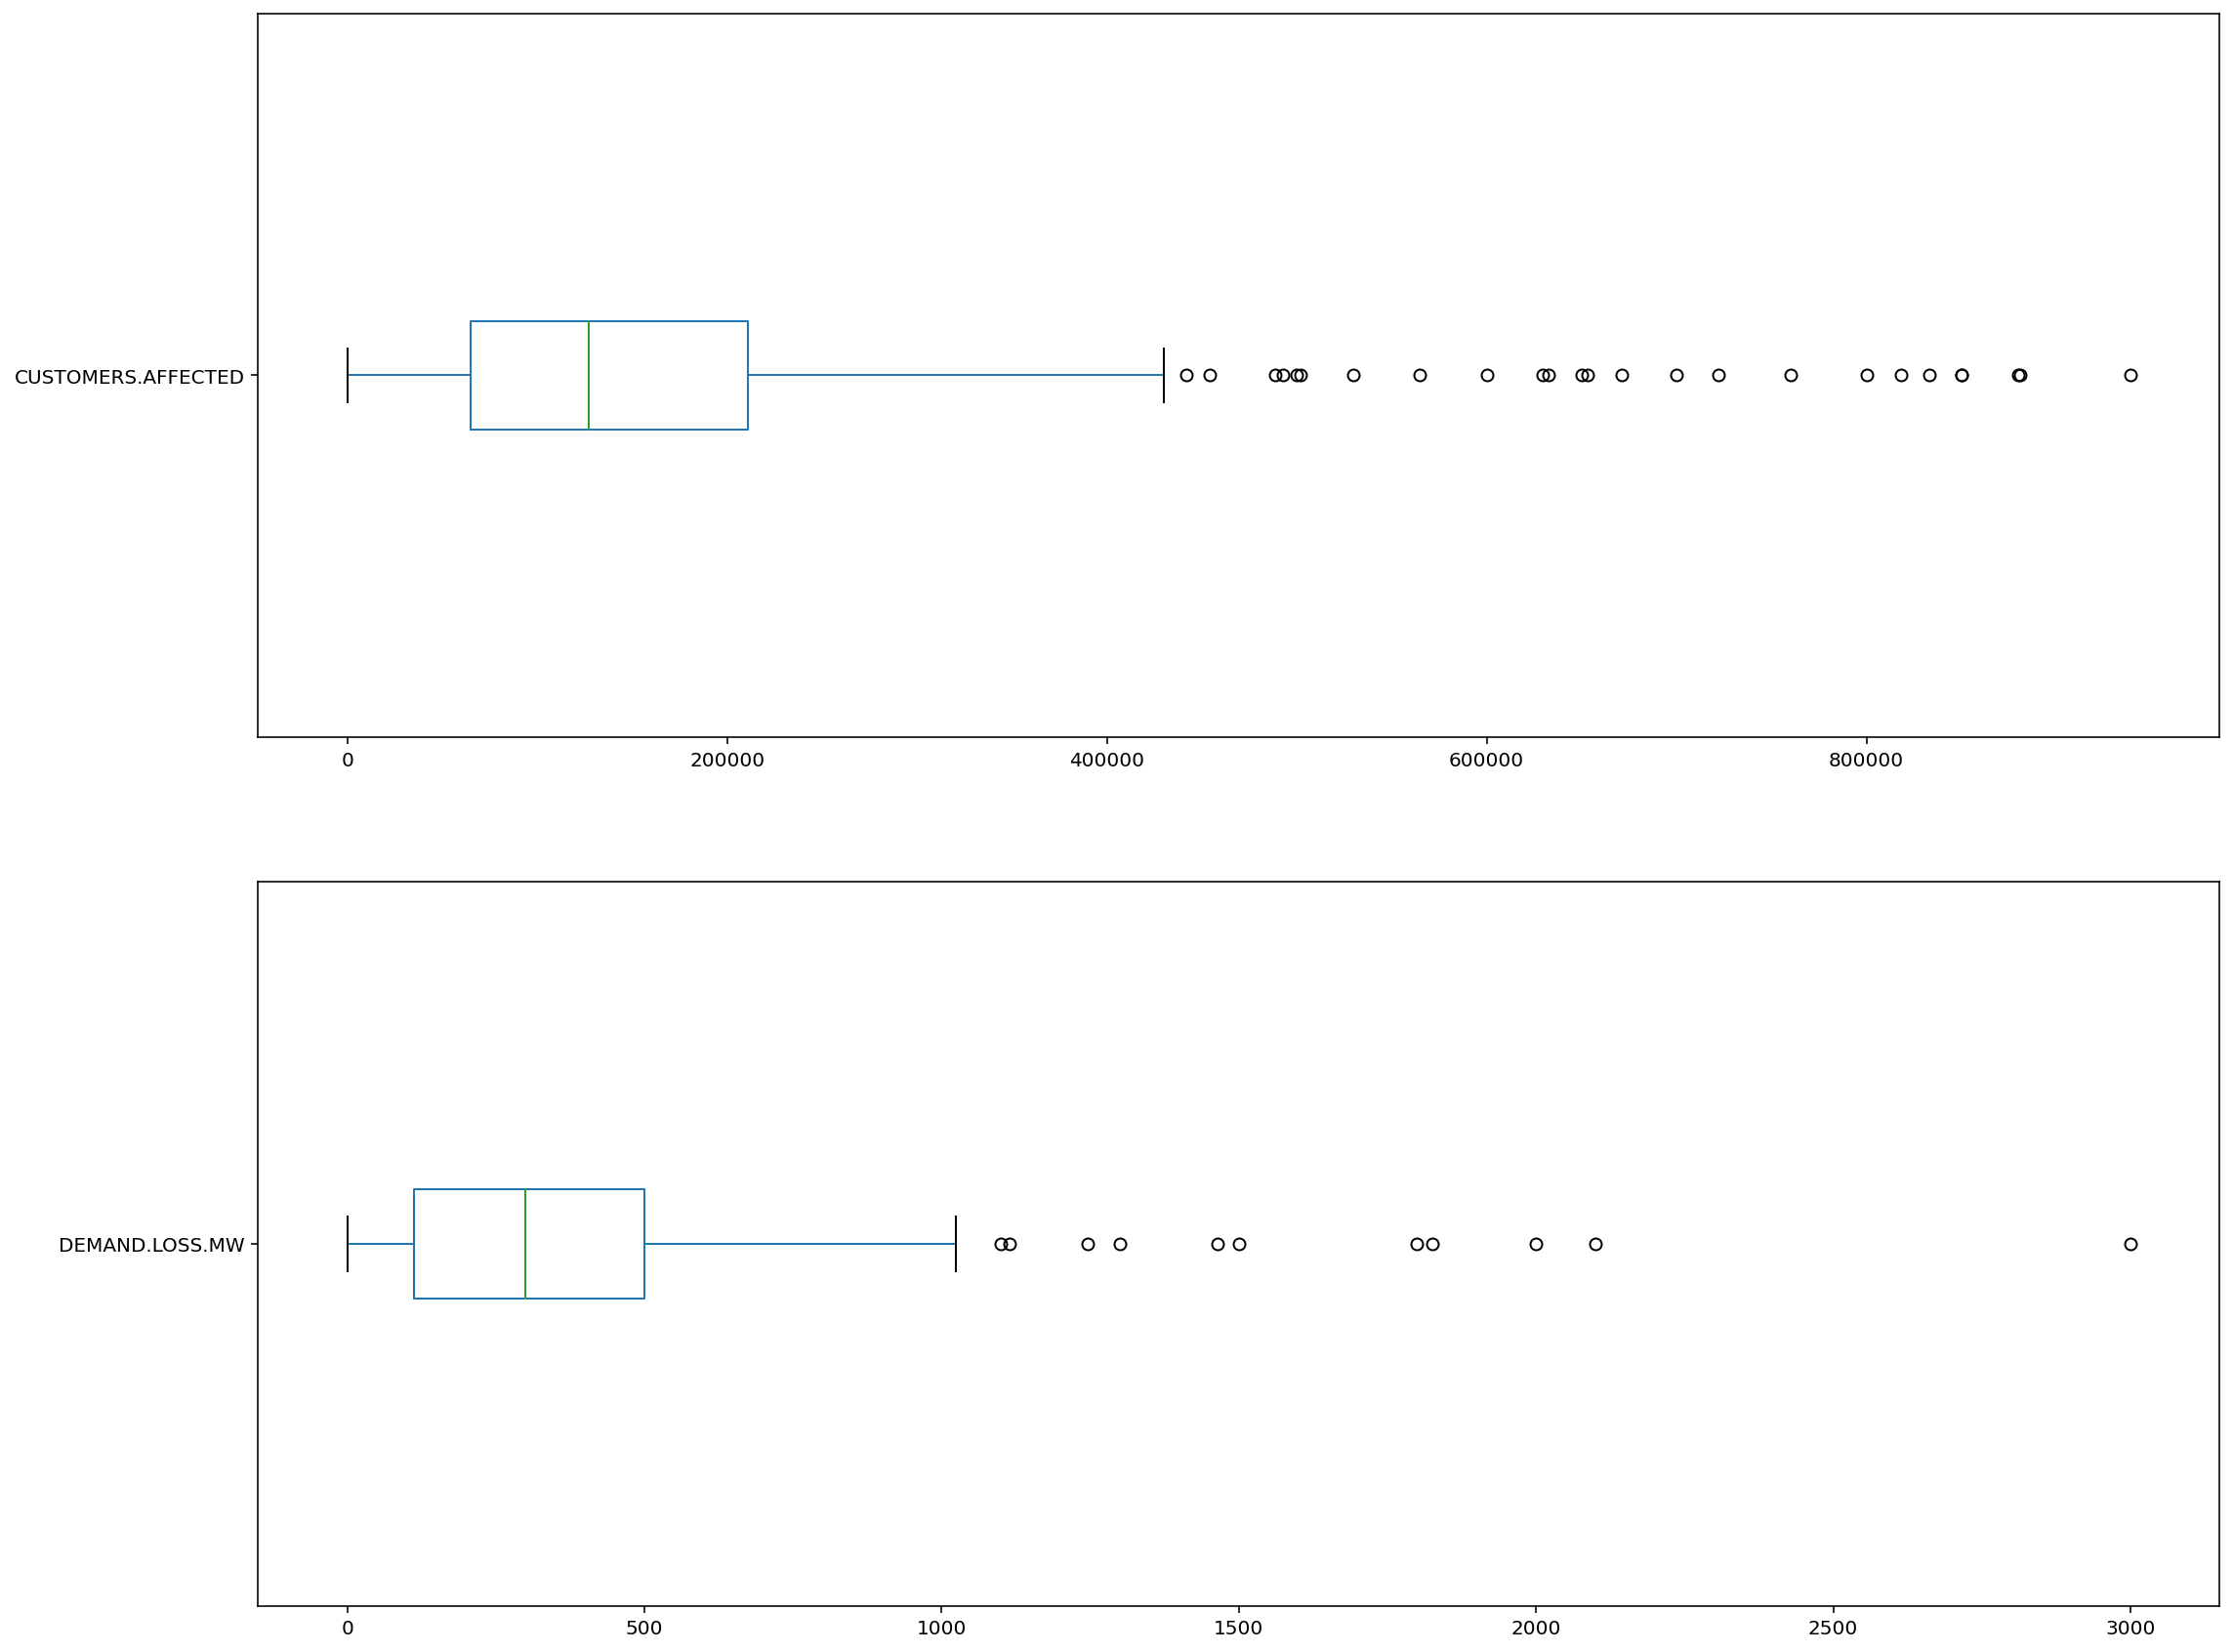

In [ ]:
figure, axis = plt.subplots(2, 1, figsize=(18, 15))

# Truncate the customers affected & demand loss columns for better observation
box_ca = major_outage[major_outage['CUSTOMERS.AFFECTED']<1_000_000]['CUSTOMERS.AFFECTED'].plot.box(ax=axis[0],vert=False)
box_dl = major_outage[major_outage['DEMAND.LOSS.MW']<5_000]['DEMAND.LOSS.MW'].plot.box(ax=axis[1],vert=False)

# Get the lower quartiles of both customers affected & demand loss columns
data_ca =major_outage.copy()['CUSTOMERS.AFFECTED'].dropna()
data_dl =major_outage.copy()['DEMAND.LOSS.MW'].dropna()
lower_quartile_ca= np.percentile(data_ca, 25)
lower_quartile_dl = np.percentile(data_dl, 25)


print(f'customers affected lower quartile: {lower_quartile_ca}')
print(f'demand loss lower quartile: {lower_quartile_dl}')

major_with_high_sev = major_outage[
    (major_outage['CUSTOMERS.AFFECTED']>lower_quartile_ca) |
  (major_outage['DEMAND.LOSS.MW']>lower_quartile_dl)
]

**Bivariate analysis for correlation between cause categories vs duration of outage/electricity loss/customers affect**

In the Bivariate analysis between "CAUSE.CATEGORY" and "CUSTOMERS.AFFECTED", we can observe that a large number of customers (upwards of 20,000) are affected because of equipment failure, severe weather, and system operability disruption. The most number of customers are affected due to severe weather and this seems intuitively right since severe weather causes power outages that last for days affecting many customers. The cause category which affects customers the least is the intentional attack category, followed by islanding and public appeal.

In the Bivariate analysis between "CAUSE.CATEGORY" and "DEMAND.LOSS", we can observe that the highest demand loss occurs when there is a fuel supply emergency This is intuitively right as due to the fuel supply emergency, there is a power outage which results in a demand loss between 150MW to 1250MW. We can observe that intentional attack and islanding have the least affect on demand loss.

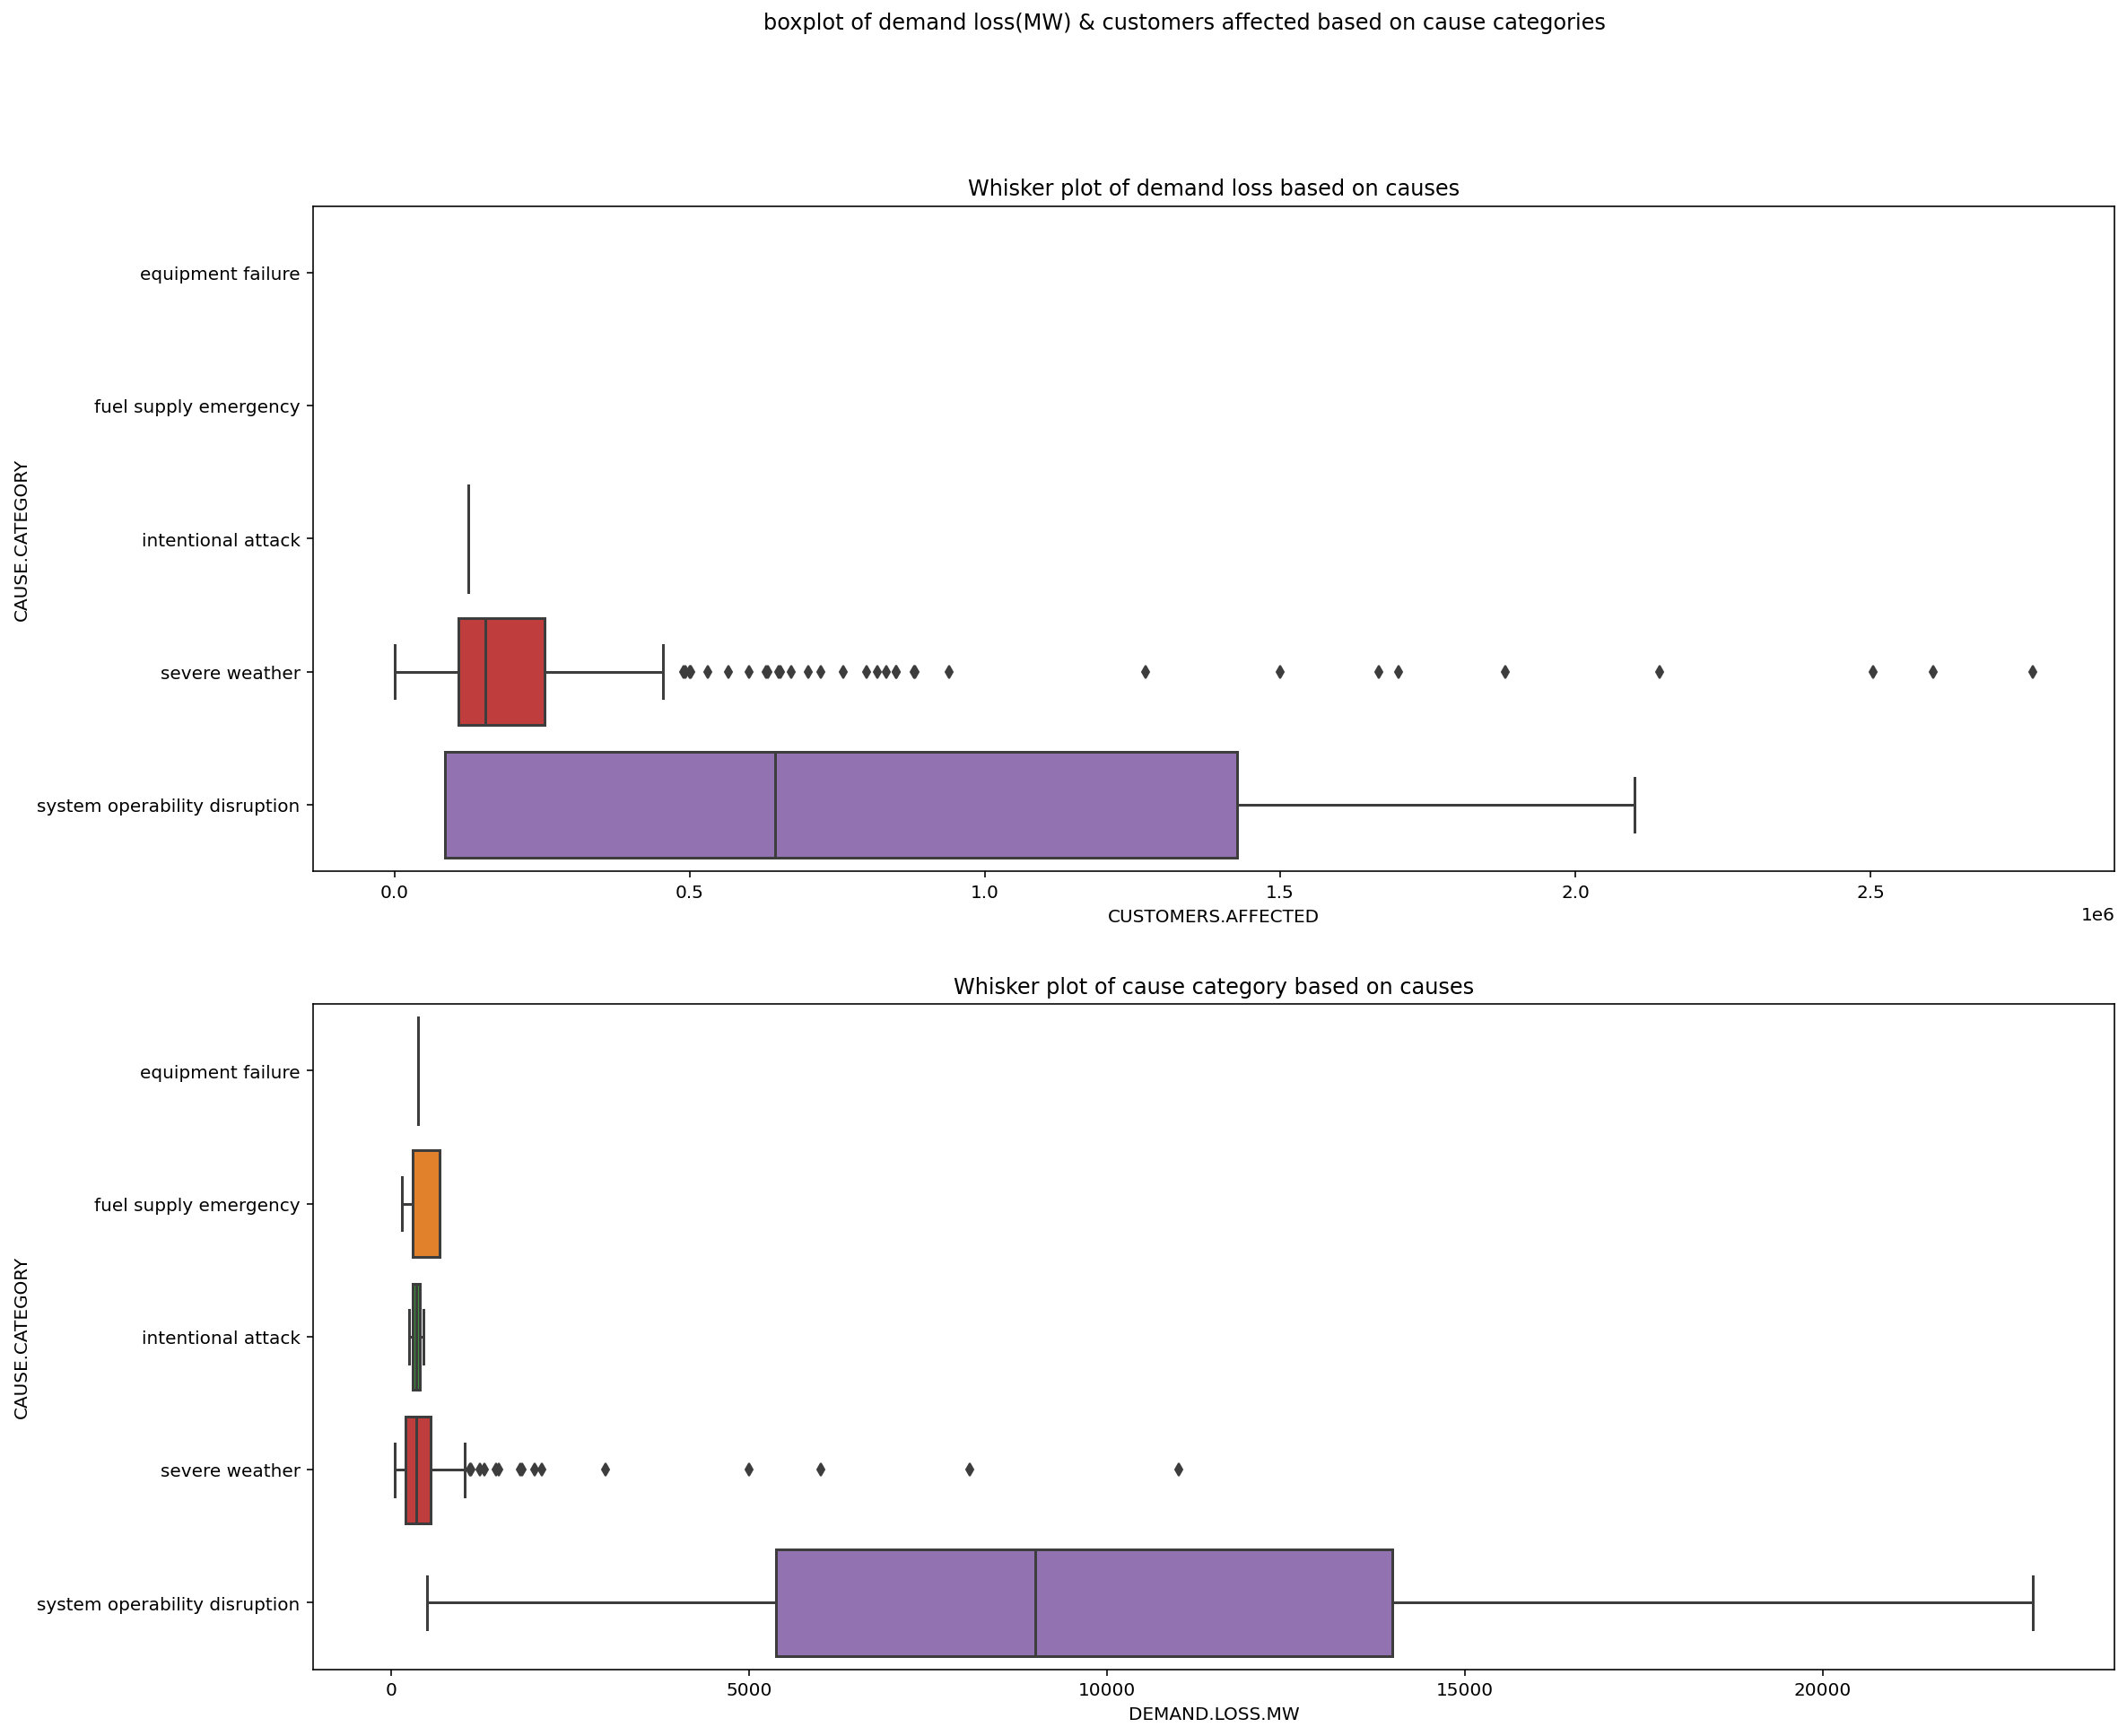

In [ ]:
# Create 2 subboxplots to display correlation between cause categories vs electricity loss/customers affected
figure, axis = plt.subplots(2, 1, figsize=(18, 15))
# Truncate the data to see a clearer picture to choose the limit for severity
dm_loss_trunc = major_with_high_sev.sort_values("CAUSE.CATEGORY")
# [major_with_high_sev['DEMAND.LOSS.MW']<3_000]
ca_trunc = major_with_high_sev.sort_values("CAUSE.CATEGORY")
# [major_with_high_sev['CUSTOMERS.AFFECTED']<150_000]
dm_cause = sns.boxplot(ax=axis[1],y="CAUSE.CATEGORY", x='DEMAND.LOSS.MW', data=dm_loss_trunc
                 ,orient="h",
                )
ca_cause = sns.boxplot(ax=axis[0],y="CAUSE.CATEGORY", x='CUSTOMERS.AFFECTED', data=ca_trunc
                 ,orient="h"
                )
figure.suptitle('boxplot of demand loss(MW) & customers affected based on cause categories')
axis[0].set_title('Whisker plot of demand loss based on causes')
axis[1].set_title('Whisker plot of cause category based on causes')
plt.show()

This map below is for counting how many major outages
incidents happen for each state and the mean duration for all of them from 2000-2016

We graphed the map to get a clearer picture of the incident counts. We also wanted to visualize the informations on the map to come up with a hypothesis question. We were able to see that the coastline states was more red than the inland states

In [ ]:
# The lambda functions below change the format of the numbers to be its correct units
# that will be displayed in the map
y = lambda x: str(round(x.mean(),3)) + '%'
kwh = lambda x: str(round(x.mean()/1_000,3)) + 'kMwh'

# this table belows aggregates count, mean of duration; mean consumption & average amount of customers
# with percentages of 3 sectors within the consumption which are residential,
# commercial & industrial shown; It also shows the percentage of land, water & inland water of a state 
state_incidents_code = major_outage.groupby(
    'POSTAL.CODE'
).aggregate(
    {'OBS':'count','OUTAGE.DURATION':np.mean
     , 'TOTAL.SALES':kwh
     ,'RES.PERCEN':y, 'COM.PERCEN':y, 'IND.PERCEN':y
#      ,'RES.SALES':y, 'COM.SALES':y, 'IND.SALES':y
     ,'TOTAL.CUSTOMERS':'mean'
     ,'RES.CUST.PCT':y
     , 'COM.CUST.PCT':y, 'IND.CUST.PCT':y
    ,'PCT_LAND': y,'PCT_WATER_TOT':y, 'PCT_WATER_INLAND':y
    }
).reset_index()


url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
us_states_url = f"{url}/us-states.json"
geoJSON_df = gpd.read_file(us_states_url)
geoJSON_df = geoJSON_df.rename(columns = {"id":"POSTAL.CODE"})

# Next we merge our sample data (df) and the geoJSON data frame on the key id.
final_df = geoJSON_df.merge(state_incidents_code, on = "POSTAL.CODE")
def get_lat_long(pt):
    '''
    Get centroid point of a state
    '''
    return (pt.y, pt.x)
final_df['coor'] = final_df['geometry'].centroid.apply(get_lat_long)

m = folium.Map(location=[48, -102], zoom_start=3)

incidents = folium.Choropleth(
    geo_data=us_states_url,
    name='Incidents_count',
    data=state_incidents_code,
    columns=['POSTAL.CODE', 'OBS'],
    key_on='feature.id',
#     threshold_scale=,
    fill_color='YlOrRd',
    fill_opacity=0.3,
    line_opacity=0.9,
    nan_fill_color = "White",
    highlight= True,
    smooth_factor=0,
#     line_color = "black",
    legend_name='Incidents counts',
).add_to(m)

# Here we add cross-hatching (crossing lines) to display the Null values.
nans = state_incidents_code[state_incidents_code["OBS"].isnull()]['POSTAL.CODE'].values
gdf_nans = state_incidents_code[state_incidents_code['POSTAL.CODE'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# Add hover functionality.
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = final_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','OBS','OUTAGE.DURATION'
                ,'TOTAL.CUSTOMERS','RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT'
               ,'TOTAL.SALES','RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN'
               ,'PCT_LAND','PCT_WATER_TOT', 'PCT_WATER_INLAND'],
        aliases=['state','incidents count','duration'
                 ,'tot_cus','res_cus','com_cus','ind_cus'
                ,'mean_usage','res_usage','com_usage','ind_usage'
                ,'land', 'water', 'inland water'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Water Color').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl(collapsed=True).add_to(m)
# state_incidents_code
outfp = "base_map.html"
m.save(outfp)
m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



This map shows the information about power outages of each state 

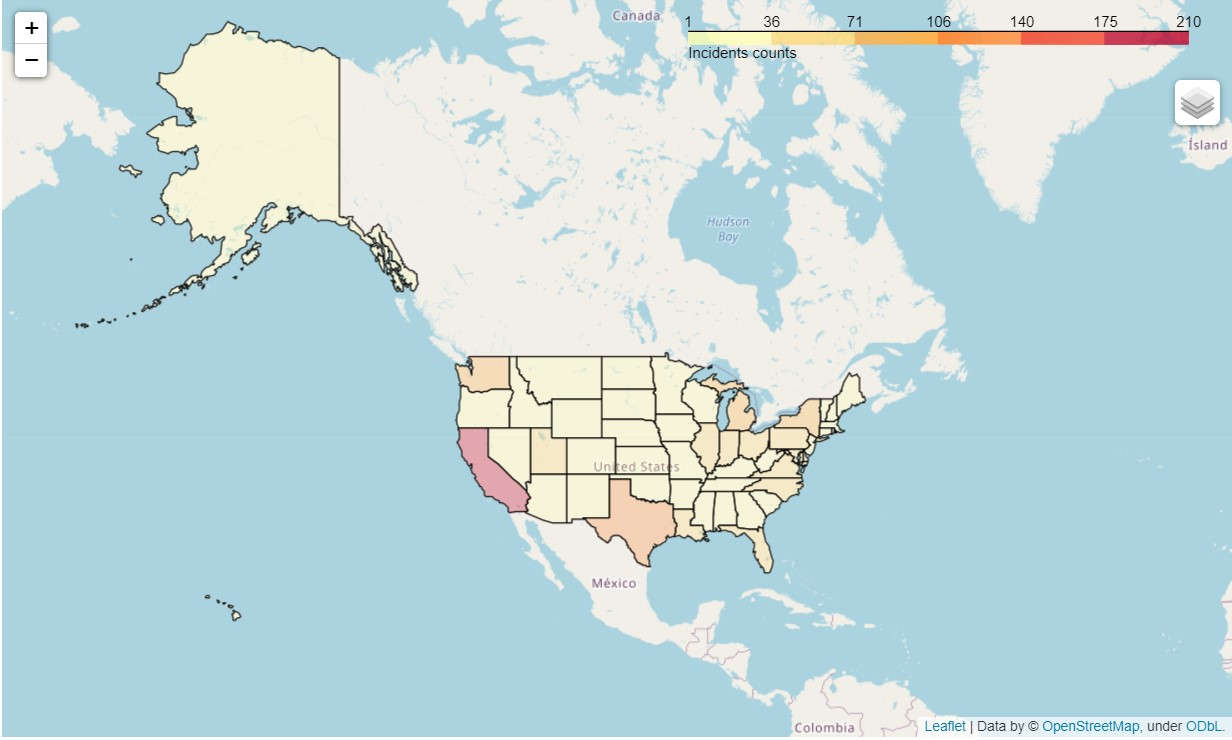

In [1]:
from IPython.display import Image
Image("initial_counts.jpg")

As you can see in the above, states in the coast experience more outages than the inland states. Even when considering major power outages with high severity shown in the map below, they still have more outages. This has led us to considering about if their duration are different

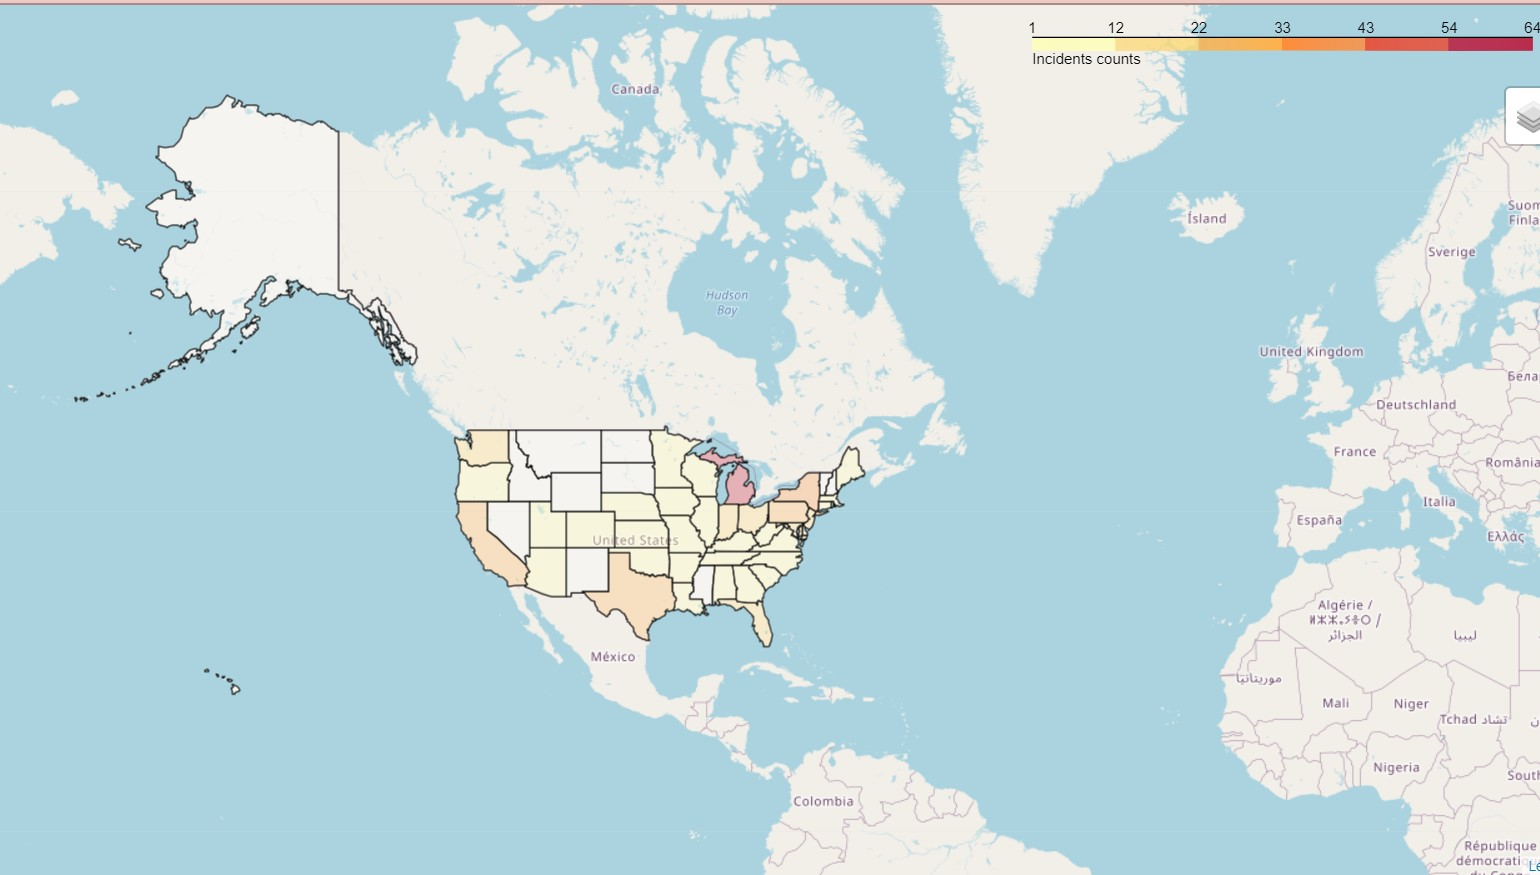

In [ ]:
from IPython.display import Image
Image("map.jpg")

The aggregation from states_incident_code where states are indices and neccessary information of each state in the map below are the columns.

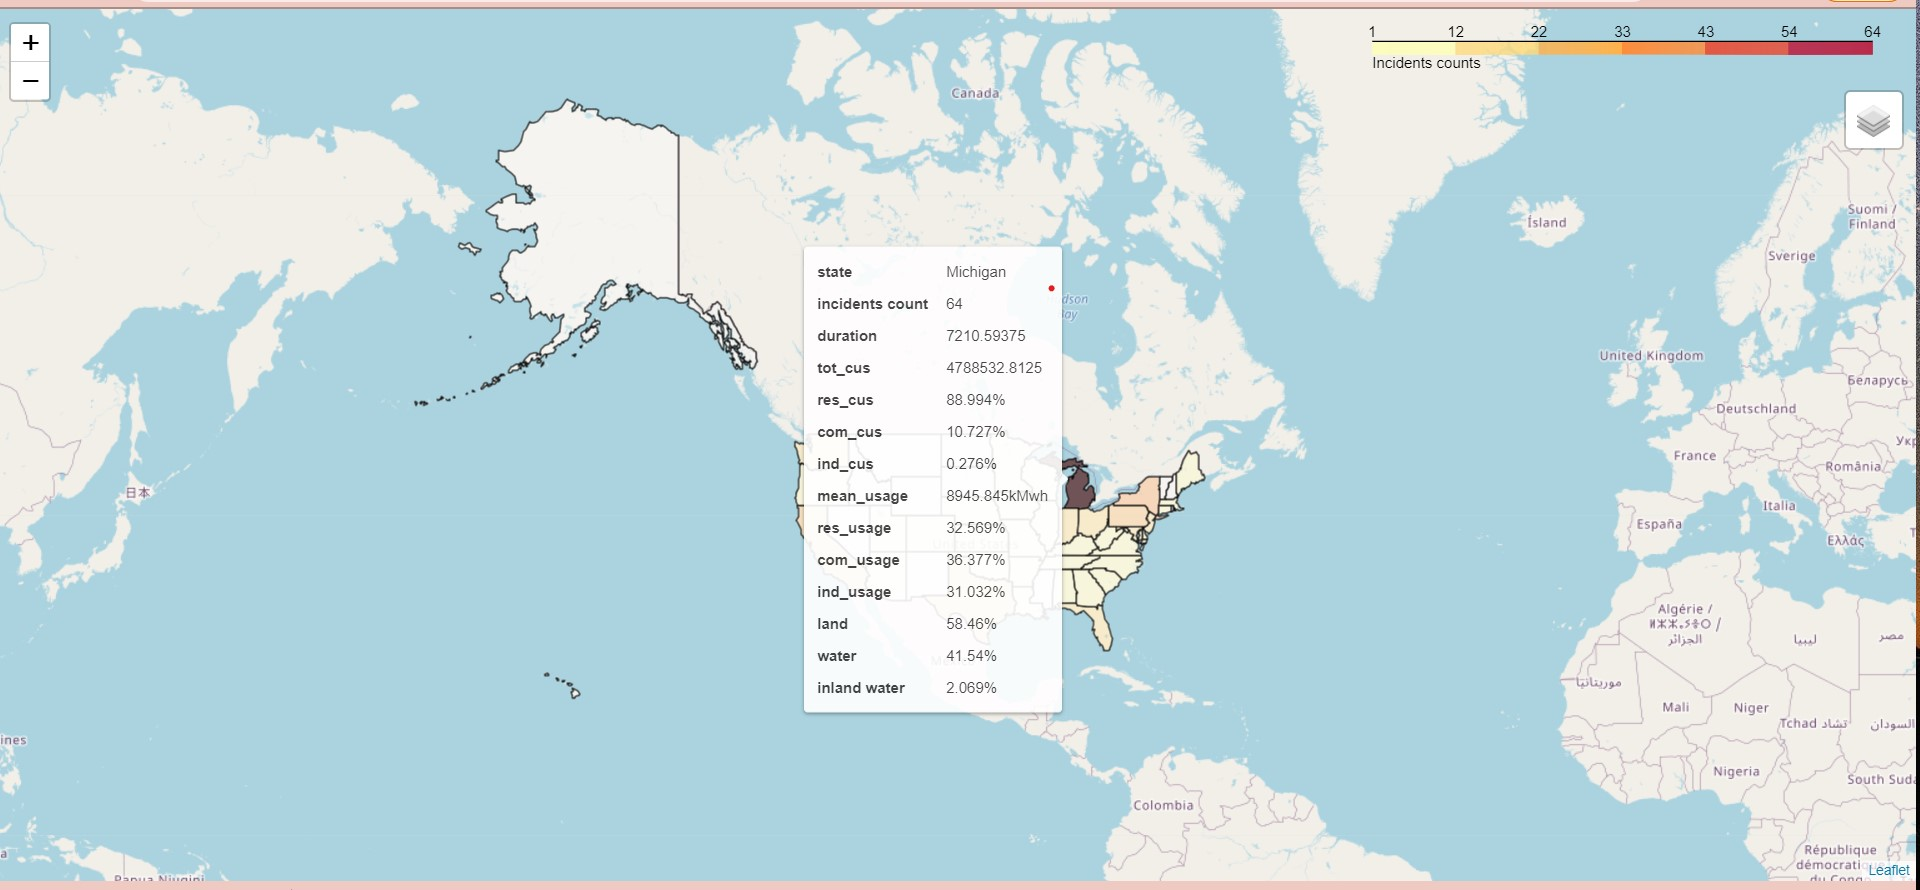

In [ ]:
from IPython.display import Image
Image("interactive.jpg")

Here is the google drive link for the [interactive map](https://drive.google.com/file/d/1q48M6hIXrEz_4uf9tuF9ryqNqhcYa4bZ/view?usp=sharing)
 in the file of html. To interact with it, you have to download and open the html file

### Assessment of Missingness

NMAR means that the probability of being missing varies for reasons that are unknown to us. In our case, the missingness in the "CUSTOMERS.AFFECTED" column could be due to other columns such as the "CAUSE.CATEGORY" column (discussed below). Another reason could be that the outage duration was so low ( <1 minute), it did not make sense to log the customers affected and hence was given "NA" in the data collection process (although this could be seen as NMAR).

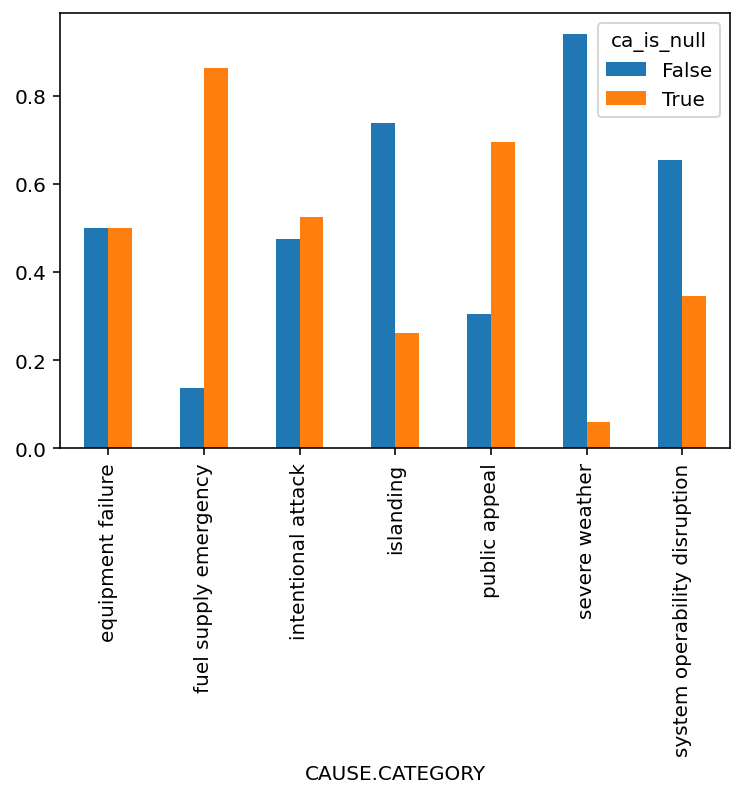

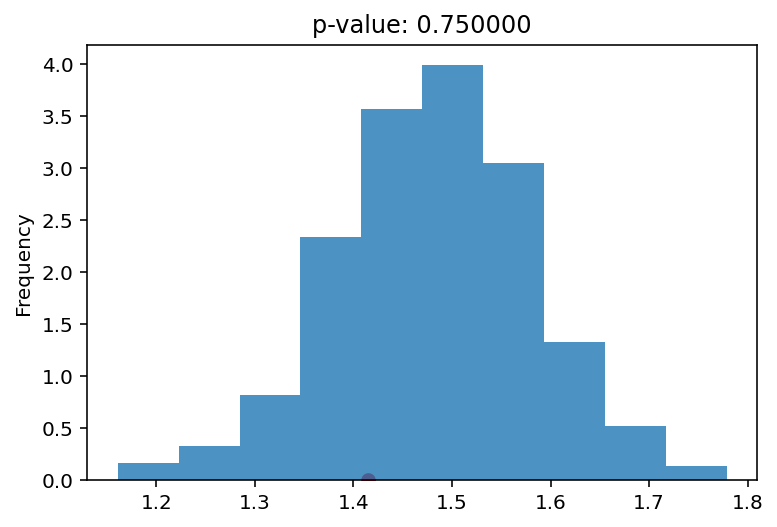

In [ ]:
# now checking for missingness of customers affected based on causes
customer_aff_null = sort_year.copy()
customer_aff_null['ca_is_null'] = sort_year['CUSTOMERS.AFFECTED'].isnull()
# distr = customer_aff_null.pivot_table(index = 'CAUSE.CATEGORY',columns='ca_is_null',aggfunc='size')
null_col = 'ca_is_null'
cnts = customer_aff_null.pivot_table(columns=null_col, index='CAUSE.CATEGORY', aggfunc='size').T
distr = cnts / cnts.sum()
distr.T.plot(kind='bar')
plt.show()
def tvd_of_groups(df,null_col,cat):
    cnts = df.pivot_table(columns=null_col, index=cat, aggfunc='size').T
    distr = cnts / cnts.sum()
    return distr.diff().iloc[-1].abs().sum()/2

obs = tvd_of_groups(customer_aff_null,'ca_is_null','CAUSE.CATEGORY')
# permutation test
n_repetitions = 500
customer_aff_null_perm = customer_aff_null[['ca_is_null','CAUSE.CATEGORY']].copy()
null_name = 'ca_is_null'
tvds = []
for _ in range(n_repetitions):
    
    # shuffle the customer affected
    mixed = np.random.permutation(customer_aff_null_perm[null_name].values)
    customer_aff_null_perm[null_name] = mixed
    
    # compute the tvd
    tvd = tvd_of_groups(customer_aff_null_perm,null_name,'CAUSE.CATEGORY')
    # add it to the list of results
    
    tvds.append(tvd)

pval = np.mean(tvds > obs)
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40)

After having used a tvd test statistic for different categories, we are quite surprised to see that the "CUSTOMERS.AFFECTED" column is not dependent on cause category, this is becase the p-value is 0.74. Hence we can move on for futher analysis by checking other columns such as the "ANOMOLY.LEVEL" column. 

---



Ks_2sampResult(statistic=0.1493959401050665, pvalue=1.3179584263944832e-06)

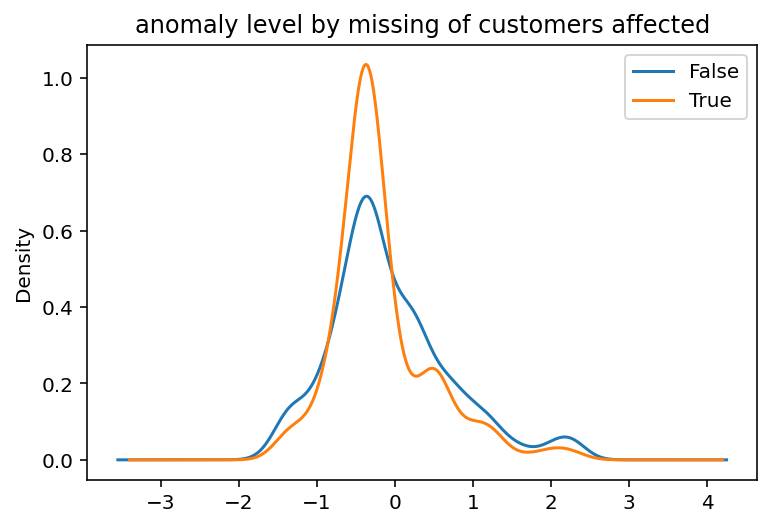

In [ ]:
# now checking for missingness of customers affected based on anomaly level
# which is checking whether climate is warm or cold based on El Nino and La Nina
from scipy.stats import ks_2samp
customer_aff_null = sort_year.copy()
customer_aff_null['ca_is_null'] = sort_year['CUSTOMERS.AFFECTED'].isnull()

# ks test
customer_aff_null_ks = customer_aff_null[['ca_is_null','ANOMALY.LEVEL']].copy()

null_name = 'ca_is_null'

(
    customer_aff_null_ks
    .groupby(null_name)['ANOMALY.LEVEL']
    .plot(kind='kde', legend=True, title='anomaly level by missing of customers affected')
)
gpA = customer_aff_null_ks.loc[customer_aff_null_ks[null_name] == True, 'ANOMALY.LEVEL']
gpB = customer_aff_null_ks.loc[customer_aff_null_ks[null_name] == False, 'ANOMALY.LEVEL']

obs = ks_2samp(gpA, gpB)
obs
# its missign at random

Using the ks-test for quantitative values, we can observe that the p value is extremely small. Hence the "CUSTOMERS.AFFECTED" column is MAR dependent on "ANOMALY.LEVEL" column. This makes sense as, if the anomaly level is low, lets say because of a very severe snow storm, it could be really hard to capture the data of customers affected, hence it could be missing at random.



checking missingness of DEMAND.LOSS.MW

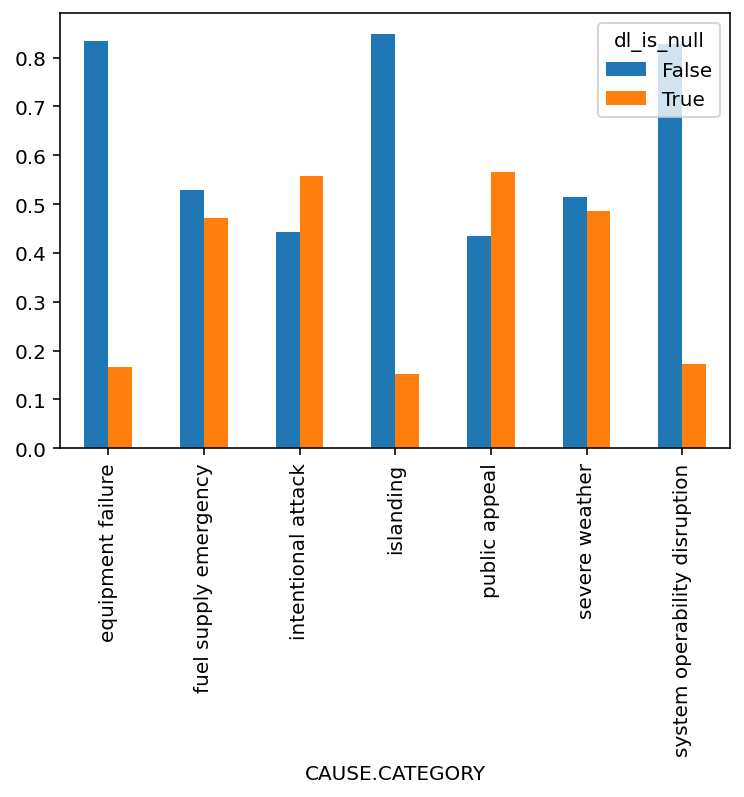

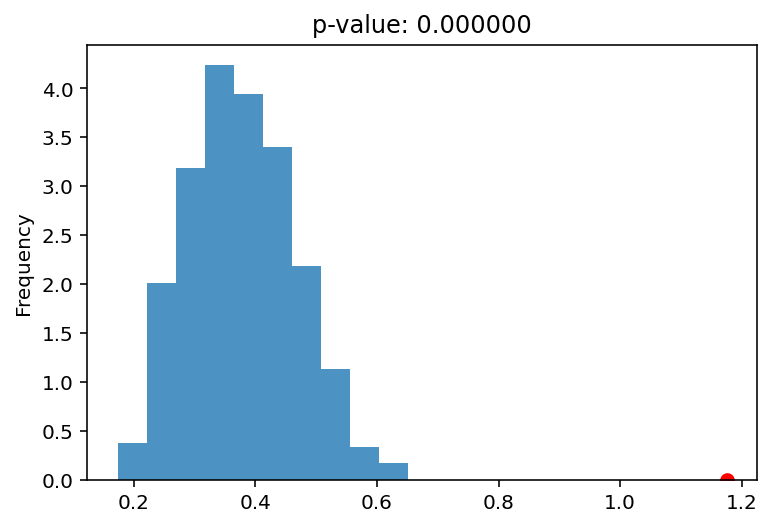

In [ ]:
# TODO
# now checking for missingness of customers affected based on causes
customer_aff_null = sort_year.copy()
# print(sort_year.info())
customer_aff_null['dl_is_null'] = sort_year['DEMAND.LOSS.MW'].isnull()

null_col = 'dl_is_null'
cnts = customer_aff_null.pivot_table(columns=null_col, index='CAUSE.CATEGORY', aggfunc='size').T
distr = cnts / cnts.sum()
distr.T.plot(kind='bar')
plt.show()
 
def tvd_of_groups(df,null_col,cat):
    cnts = df.pivot_table(columns=null_col, index=cat, aggfunc='size').T
    distr = cnts / cnts.sum()
    return distr.diff().iloc[-1].abs().sum()/2

obs = tvd_of_groups(customer_aff_null,null_col,'CAUSE.CATEGORY')
# permutation test
n_repetitions = 500
customer_aff_null_perm = customer_aff_null[[null_col,'CAUSE.CATEGORY']].copy()
tvds = []
for _ in range(n_repetitions):
    
    # shuffle the gender column
    mixed = np.random.permutation(customer_aff_null_perm[null_col].values)
    customer_aff_null_perm[null_col] = mixed
    
    # compute the tvd
    tvd = tvd_of_groups(customer_aff_null_perm,null_col,'CAUSE.CATEGORY')
    # add it to the list of results
    
    tvds.append(tvd)
pval = np.mean(tvds > obs)
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(obs, 0, color='red', s=40)

Conclusion for missingness of DEMAND.LOSS.MW column which represents *Amount of peak demand lost during an outage event (in Megawatt)*

This is MAR depedent on the CAUSE.CATEGORY column. A possible explanation is that they cannnot report the loss because of the severity of the incidents that cause impossible estimation for the whole big area

### Hypothesis Test

Null hypothesis: The states that are next to water suffered the same outage duration as those that are inland

Alternative hypothesis: The states that are coastline have suffered longer major outages than those that are inland

Create a graph to check whether the state is inland or not by comparing water area & inland water area
water area includes inland water and surrounded water which means that the states that are fully
landlocked do not water as their borders

In [ ]:
land_check = sort_year[['U.S._STATE','PCT_LAND','PCT_WATER_TOT', 'PCT_WATER_INLAND']]
sort_year['U.S._STATE'].unique()
inland_states = land_check.drop_duplicates(subset = 'U.S._STATE').sort_values('U.S._STATE')

inland_states['inland_state'] = inland_states['PCT_WATER_TOT'] == inland_states['PCT_WATER_INLAND']
inland_states.sort_values('inland_state')

,U.S._STATE,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,inland_state
14,Alabama,96.613888,3.386112,2.018314,False
32,Massachusetts,73.905628,26.094372,4.604889,False
44,Michigan,58.459995,41.540005,2.068987,False
191,Minnesota,91.592666,8.407334,5.478743,False
63,Wisconsin,82.689019,17.312508,3.049041,False
309,New Hampshire,95.764253,4.246443,3.508397,False
237,New Jersey,84.305858,15.682678,4.998280,False
7,New York,86.382550,13.617450,3.645862,False
8,North Carolina,90.336127,9.663873,7.528940,False
13,Ohio,91.154687,8.845313,1.057422,False


p-value of the Kolmogorov–Smirnov test is 0.039675396208982736


Ks_2sampResult(statistic=0.25, pvalue=0.039675396208982736)

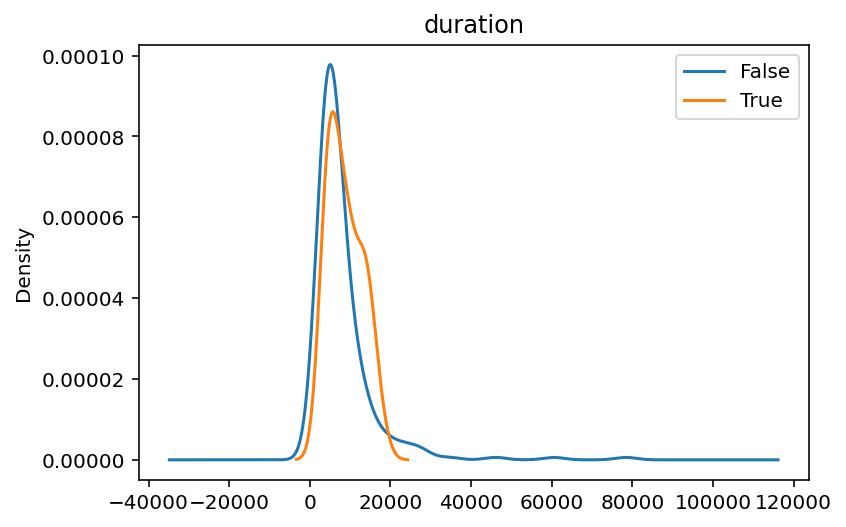

In [ ]:
# Select only related column to reduce memory
hypo = major_with_high_sev[['U.S._STATE','OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED','ANOMALY.LEVEL']].copy()
select_dl = inland_states[['U.S._STATE','inland_state']].copy()

# Merge a table that represents whether the state is inland or not
hypo_check = hypo.merge(select_dl, how='inner', on='U.S._STATE')

inland_check = 'inland_state'
severe_check = 'OUTAGE.DURATION'
# ks test
(
    hypo_check
    .groupby('inland_state')[severe_check]
    .plot(kind='kde', legend=True, title='duration')
)
gpA = hypo_check.loc[hypo_check['inland_state'] == False, severe_check]
gpB = hypo_check.loc[hypo_check['inland_state'] == True, severe_check]

# we use alternative = 'greater' argument which 
# makes ks test use 1-sided test because we explicitly
# say that the duration of coastal states is higher than the inland
# states

obs = ks_2samp(gpA, gpB,alternative='greater')
print(f'p-value of the Kolmogorov–Smirnov test is {obs.pvalue}')
obs

By using 5% signicance level & Kolmogorov–Smirnov test,
we have the test statistic to be .25 and reject the null hypothesis
that the major power outage with high severity of inland states 
does not have the same distribution as coastal states since the
p-value is roughly 0.03968

The reason I use the KS test is that I can compare the difference
between the duration of 2 types of states by looking at the largest
gap